In [1]:
using NLsolve
#using Plots
using BenchmarkTools
using Distributed
if nprocs() == 1
#    addprocs(7)
end
@everywhere using SharedArrays
@everywhere configFile = "config.toml"
@everywhere include("src/ladderDGA_Julia.jl")

[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi


Writing HDF5 (vars.jdl) and Fortran (fortran_out/) output.


┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main ~/Hamburg/ladderDGA_Julia/src/helpers.jl:176
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│       sp: 37
│       ch: 23 
└       χLoc_sp = 0.4226, χLoc_ch = 0.0612


In [2]:
@time bubble = calc_bubble_fft(GLoc_fft, length(qIndices), modelParams, simParams);

  1.655670 seconds (3.35 M allocations: 261.873 MiB, 7.03% gc time)


In [7]:
ind = 10
gridShape = repeat([simParams.Nk], modelParams.D)
GLoc = flatten_2D(G_from_Σ(Σ_loc, ϵkGrid, fft_range, modelParams));
GLoc_fft = Gfft_from_Σ(Σ_loc, ϵkGrid, fft_range, modelParams);
res1 = ifft(fft(reshape(GLoc[ind,:], gridShape...)) .* fft(reshape(GLoc[ind+2,:], gridShape...)));
res2 = ifft(reshape(GLoc_fft[ind,:], gridShape...) .* reshape(GLoc_fft[ind+2,:], gridShape...));

In [45]:
testf(x) = (real.(sum(ifft(fft(reshape(GLoc[ind,:] .+ x, gridShape...)) .* fft(reshape(GLoc[ind+2,:], gridShape...)))) .- 0.5),imag.(sum(ifft(fft(reshape(GLoc[ind,:] .+ x, gridShape...)) .* fft(reshape(GLoc[ind+2,:], gridShape...))))));
testf2(x) = real.(sum(ifft(fft(reshape(GLoc[ind,:] .+ x, gridShape...)) .* fft(reshape(GLoc[ind+2,:], gridShape...)))));

In [46]:
testf2(1)

-14484.144294909827

In [12]:
using Zygote

In [47]:
h_tf1(y) = Zygote.hessian(testf,y)
h_tf2(y) = Zygote.gradient(testf2,y)

h_tf2 (generic function with 1 method)

In [48]:
h_tf2(0.1)

(3.000932835561798e-10 - 126455.59925073668im,)

In [58]:
include("src/ladderDGATools.jl")

Σ_DMFT_correction (generic function with 0 methods)

In [51]:
f(x) = sum(calc_bubble_fft(GLoc_fft .+ x, length(qIndices), modelParams, simParams)) .- 20768.7
roots(f, -0.1..0.1)

MethodError: MethodError: no method matching Float64(::Interval{Float64})
Closest candidates are:
  Float64(::Real, !Matched::RoundingMode) where T<:AbstractFloat at rounding.jl:200
  Float64(::T) where T<:Number at boot.jl:715
  Float64(!Matched::Int8) at float.jl:60
  ...

In [11]:
@time bubble = calc_bubble_fft(GLoc_fft, length(qIndices), modelParams, simParams);

on procs: 1
  0.083046 seconds (2.39 k allocations: 3.342 MiB)


In [18]:
@everywhere include("src/ladderDGATools.jl")
χsp, χsp_ω, γsp, usable_sp = calc_χ_trilex(Γsp, bubble, qMultiplicity, modelParams.U, modelParams.β, tc=false, fullRange=false)

CompositeException: TaskFailedException:
On worker 2:
UndefVarError: ωindices not defined
macro expansion at /home/julian/Hamburg/ladderDGA_Julia/src/ladderDGATools.jl:37 [inlined]
#664 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/macros.jl:302
#158 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/macros.jl:87
#101 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/process_messages.jl:290
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/process_messages.jl:79
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/process_messages.jl:88
#94 at ./task.jl:358

...and 6 more exception(s).

Stacktrace:
 [1] sync_end(::Array{Any,1}) at ./task.jl:316
 [2] (::Distributed.var"#157#159"{var"#664#666"{Bool,SharedArray{Complex{Float64},3},SharedArray{Complex{Float64},3},Array{Float64,1},Float64,Float64,Nothing,SharedArray{Complex{Float64},2},SharedArray{Complex{Float64},3},SharedArray{Complex{Float64},1},Array{Complex{Float64},2}},UnitRange{Int64}})() at ./task.jl:335

In [12]:
@everywhere include("src/ladderDGATools.jl")

In [13]:
3

[ Info: Reading Inputs...
[ Info: Calculating bubble: 


  0.158672 seconds (272.31 k allocations: 12.725 MiB)
  0.386618 seconds (722.51 k allocations: 114.030 MiB, 12.75% gc time)


[ Info: Calculating χ and γ: 
[ Info: TODO: use strcut for local and DMFT quantities


  2.966489 seconds (6.46 M allocations: 342.341 MiB, 4.48% gc time)
  8.247106 seconds (739.94 k allocations: 1.640 GiB, 1.67% gc time)


┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 26:36, length: 11
│ ch: 27:35, length: 9
└ usable: 27:35, length: 9
┌ Info: Using rhs for non tail corrected lambda correction: 
│   rhs = 0.3707200196449585
│    =  = " = "
│   χLocch = 0.0164936206442667 + 2.757268708510092e-26im
│    +  = " + "
│   χLocsp = 0.36979824957558627 - 1.1718392011167892e-25im
│    -  = " - "
└   χch_sum = 0.015571850574894462 - 5.514537417020184e-26im
[ Info: Calculating λ correction in the spin channel: 


TODO: lambda tc


┌ Info: found 
│   χ_min = 0.09534722249428645
│   . Looking for roots in intervall  = ". Looking for roots in intervall "
│   int =
│    2-element Array{Float64,1}:
│     0.09434722249428645
└     0.19534722249428646
┌ Info: possible roots: 
│   r =
│    2-element Array{Root{Interval{Float64}},1}:
│     Root([0.095347, 0.0953472], :unknown)
└     Root([0.096757, 0.0967571], :unique)


  4.455468 seconds (7.97 M allocations: 383.067 MiB, 3.68% gc time)


┌ Info: Found λsp 
└   λsp = 0.09675706412746195
┌ Info: computing λ corrected χsp, using 
│   simParams.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."


DEBUG: computing 2 versions of Sigma


[ Info: Calculating Σ ladder: 


  1.540991 seconds (2.77 M allocations: 136.744 MiB, 3.33% gc time)
  1.471884 seconds (4.17 M allocations: 281.722 MiB, 5.87% gc time)


In [14]:
function construct_f!(F, λ, rhs)#default rhs χLocsp + χLocch or n/2 (1-n/2)
    χsp_λ = χ_λ(rχ_sp, λ[1])
    χch_λ = χ_λ(rχ_ch, λ[2]) 
    tmp =  sum(sum(χch_λ .+ χsp_λ, dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity))           
    F[1] = real(tmp - rhs)
end

function construct_f(λsp, λch, χsp, χch, qMultiplicity; rhs=0.5) 
   χch_λ = χ_λ(χch, λch)
   χsp_λ = χ_λ(χsp, λsp)
   tmp =  sum(sum(χch_λ .+ χsp_λ, dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity))           
   res1 = tmp - rhs
   return res1
end

construct_f (generic function with 1 method)

# Condition 1

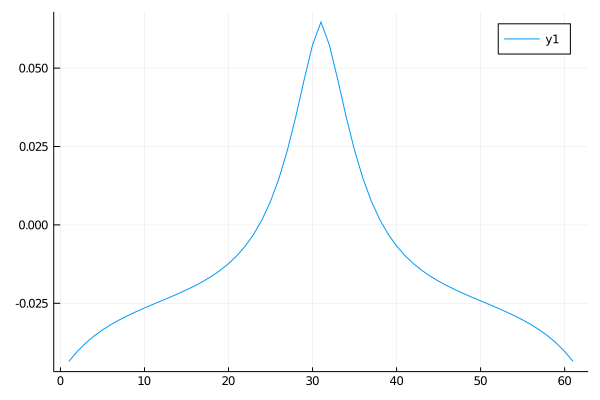

In [147]:
plot(real.(χch)[:,56])

In [15]:
usable_ω = intersect(usable_sp, usable_ch);
rχsp = real.(χsp[usable_ω,:]);
rχch = real.(χch[usable_ω,:]);

## Testing NLsolve vs Roots

In [16]:
upper_lim = 1.2
testf!(F,λ) = F[1]=construct_f(λ[1], 0.0, rχsp, rχch, qMultiplicity, rhs=real(χLocsp + χLocch))
testf(λsp) = construct_f(λsp, 0.0, rχsp, rχch, qMultiplicity, rhs=real(χLocsp + χLocch))
res_nls = nlsolve(testf!, [upper_lim], autodiff = :forward)
Xsp = @interval(0.0,upper_lim)
res_roots = roots(testf, Xsp, Newton, 1e-10)
max_int = mid(maximum(interval.(res_roots)))

0.09675177839405225

## compute λsp(λch)

In [17]:
λch_range = -2:0.01:2
spOfch_max_nl = zeros(size(λch_range))
for (λi,λchi) in enumerate(λch_range)
    testf!(F,λ) = F[1]=construct_f(λ[1], λchi, rχsp, rχch, qMultiplicity, rhs=real(χLocsp + χLocch))
    res = nlsolve(testf!, [0.5], autodiff = :forward)
    spOfch_max_nl[λi] = res.zero[1]
end

In [144]:
Xsp = @interval(0.01,0.1)
Xch = @interval(-2,2)
λch_range_c1 = -6.0:0.3:6.0
λch_range2_c1 = -20:0.5:20
spOfch_max_int_c1 = zeros(size(λch_range_c1))
spOfch2_max_int_c1 = zeros(size(λch_range2_c1))
spOfch3_max_int_c1 = zeros(size(λch_range2_c1))

#for (λi,λchi) in enumerate(λch_range_c1)
#    testf(λsp) = construct_f(λsp, λchi, real.(χsp), real.(χch), qMultiplicity, rhs=real(χLocsp + χLocch))
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch_max_int_c1[λi] = mid(max_int)
#    print("\r", λi, " of ", length(λch_range))
#end

for (λi,λchi) in enumerate(λch_range2_c1)
    testf(λsp) = construct_f(λsp, λchi, real.(χsp), real.(χch), qMultiplicity, rhs=real(χLocsp + χLocch))
    res_internal = roots(testf, Xsp, Newton, 1e-5)
    max_int = maximum(interval.(res_internal))
    spOfch2_max_int_c1[λi] = mid(max_int)
    print("\r", λi, " of ", length(λch_range2_c1))
end

for (λi,λchi) in enumerate(λch_range2_c1)
    testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, qMultiplicity, rhs=real(χLocsp + χLocch))
    res_internal = roots(testf, Xsp, Newton, 1e-5)
    max_int = maximum(interval.(res_internal))
    spOfch3_max_int_c1[λi] = mid(max_int)
    print("\r", λi, " of ", length(λch_range2_c1))
end

81 of 81

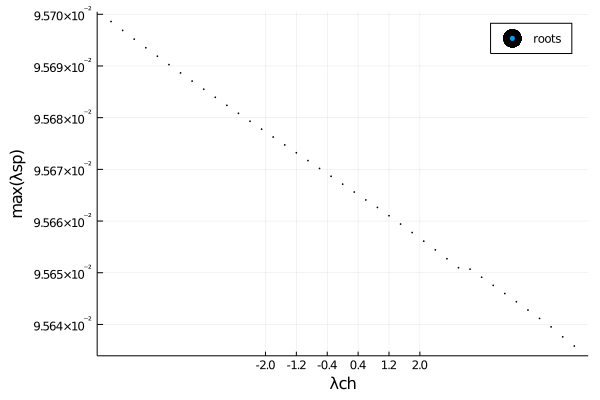

In [142]:
plot(λch_range_c1, spOfch_max_int_c1, label="roots", xlabel="λch", ylabel="max(λsp)", xticks = λch_range[1:80:end],seriestype = :scatter, markersize=0.8)
#plot!(λch_range, spOfch_max_nl, label="NLsolve", seriestype = :scatter, markersize=0.8)

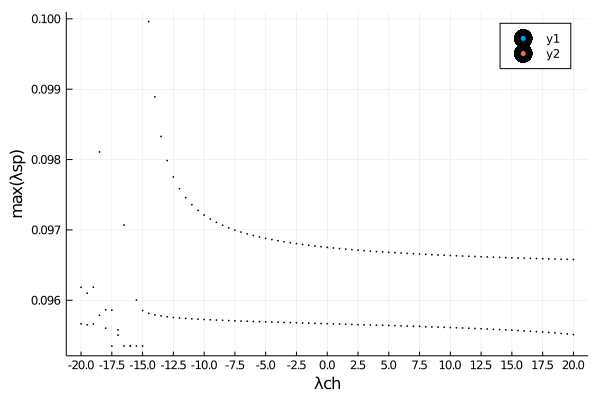

In [145]:
plot(λch_range2_c1[1:end], spOfch2_max_int_c1[1:end], xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:5:end],seriestype = :scatter, markersize=0.8)
plot!(λch_range2_c1[1:end], spOfch3_max_int_c1[1:end], xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:5:end],seriestype = :scatter, markersize=0.8)

#savefig("max_lambdasp_of_lambdach.pdf")

# Condition 2

## Full vs. Cut
### ToDo: justify one or the other

In [27]:
bubbleLoc = calc_bubble_fft(GImpSym, 1, modelParams, simParams);
χspLoc, χchLoc, _, _, trilexspLoc, trilexchLoc, _, _ =
        calc_χ_trilex(Γsp, Γch, bubbleLoc, [1], modelParams, simParams);
Σ_ladderLoc_full = calc_DΓA_Σ_fft(χspLoc, χchLoc, trilexspLoc, trilexchLoc, bubbleLoc, GImpSym, FUpDo, 
                                           [1], 1:size(bubble,1), 1:simParams.n_iν, 1,
                                           modelParams, simParams, simParams.tail_corrected)
Σ_ladderLoc_full = Σ_ladderLoc_full .+ modelParams.n * modelParams.U/2.0;

Σ_ladder_full = calc_DΓA_Σ_fft(χsp_λ, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                                  qIndices, 1:size(bubble,1), 1:simParams.n_iν, simParams.Nk,
                                  modelParams, simParams, simParams.tail_corrected)
Σ_ladder_full_corrected = Σ_ladder_full .- Σ_ladderLoc_full .+ Σ_loc[eachindex(Σ_ladderLoc_full)]

χsp_λ = χ_λ(χsp, 0.096757064296870768)
χch_λ = χ_λ(χch, 0.0)
mP = modelParams
sP = simParams
Σ_λ = calc_DΓA_Σ_fft(χsp_λ, χch_λ, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                    qIndices, usable_ω, 1:simParams.n_iν, simParams.Nk,
                    modelParams, simParams, simParams.tail_corrected)
Σ_λ_corrected = Σ_λ .- Σ_ladderLoc_cut .+ Σ_loc[1:length(Σ_ladderLoc_cut)]
E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid_red, mP, sP)
[mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)); E_Pot]


MethodError: MethodError: no method matching cut_mirror(::Array{Float64,1})
Closest candidates are:
  cut_mirror(!Matched::Base.Iterators.ProductIterator) at /home/julian/Hamburg/ladderDGA_Julia/src/dispersion.jl:254
  cut_mirror(!Matched::Array{T,2}) where T at /home/julian/Hamburg/ladderDGA_Julia/src/dispersion.jl:255
  cut_mirror(!Matched::Array{T,3}) where T at /home/julian/Hamburg/ladderDGA_Julia/src/dispersion.jl:256

## Condition 2

In [28]:
@everywhere function calc_E_Pot(Σ_ladder, ϵkGrid_red, mP::ModelParameters, sP::SimulationParameters; weights=nothing)::Float64
    νGrid = 0:simParams.n_iν-1
    Σ_hartree = mP.n * mP.U/2
    tail_corr_0 = 0.0
    tail_corr_inv_0 = mP.β * Σ_hartree/2
    tail_corr_1 = (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (ϵkGrid_red .+ Σ_hartree .- mP.μ))' ./ (iν_array(mP.β, 0:(sP.n_iν-1)) .^ 2)
    tail_corr_inv_1 = 0.5 * mP.β * (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (ϵkGrid_red .+ Σ_hartree .- mP.μ))
    res = 0.0
    
    Σ_ladder_corrected = Σ_ladder.+ Σ_hartree
    G_new = flatten_2D(G_from_Σ(Σ_ladder_corrected, ϵkGrid_red, νGrid, mP));

    norm = (mP.β * sP.Nk^mP.D)
    tmp = real.(G_new .* Σ_ladder_corrected .+ tail_corr_0 .- tail_corr_1);
    if weights != nothing
        res = [sum( (2 .* sum(tmp[1:i,:], dims=[1])[1,:] .+ tail_corr_inv_0 .- tail_corr_inv_1 .* 0.5 .* mP.β) .* qMultiplicity) / norm for i in 1:sP.n_iν]
        res = fit_νsum(weights, res[(end-size(weights,2)+1):end])
    else
        res = sum( (2 .* sum(tmp, dims=[1])[1,:] .+ tail_corr_inv_0 .- tail_corr_inv_1 .* 0.5 .* mP.β) .* qMultiplicity) / norm 
    end
    return res
end


@everywhere function cond_Epot2(λsp, λch, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc, ϵkGrid_red, qIndices, usable_ω, usable_ν, mP, sP)
    χsp_λ = χ_λ(χsp, λsp)
    χch_λ = χ_λ(χch, λch)
    #println(λsp, ", ", λch)
    Σ_λ = calc_DΓA_Σ_fft(χsp_λ, χch_λ, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         qIndices, usable_ω, 1:simParams.n_iν, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Σ_λ_corrected = Σ_λ .- Σ_ladderLoc .+ Σ_loc[1:length(Σ_ladderLoc)]
    E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid_red, mP, sP)
    mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)) - E_Pot
end

function cond_Epot2_r(λsp, λch, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc, ϵkGrid_red, qIndices, usable_ω, usable_ν, mP, sP)
    χsp_λ = χ_λ(χsp, λsp)
    χch_λ = χ_λ(χch, λch)
    χsp_λ2 = typeof(λsp) <: Interval ? χ_λ(χsp, mid(λsp)) : χ_λ(χsp, λsp)
    χch_λ2 = typeof(λch) <: Interval ? χ_λ(χch, mid(λch)) : χ_λ(χch, λch)
    Σ_λ = calc_DΓA_Σ_fft(χsp_λ2, χch_λ2, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         qIndices, usable_ω, 1:simParams.n_iν, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Σ_λ_corrected = Σ_λ .- Σ_ladderLoc .+ Σ_loc[1:length(Σ_ladderLoc)]
    E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid_red, mP, sP)
    mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)) - E_Pot
end

@everywhere function cond_Epot2_overview(λsp, λch, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc, ϵkGrid_red, qIndices, usable_ω, usable_ν, mP, sP)
    χsp_λ = χ_λ(χsp, λsp)
    χch_λ = χ_λ(χch, λch)
    Σ_λ = calc_DΓA_Σ_fft(χsp_λ, χch_λ, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         qIndices, usable_ω, 1:simParams.n_iν, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Σ_λ_corrected = Σ_λ .- Σ_ladderLoc .+ Σ_loc[1:length(Σ_ladderLoc)]
    E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid_red, mP, sP)
    [mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)); E_Pot]
end

In [29]:

λch_range_c2 = -6.0:0.3:6.0
λsp_range_c2 = 0.095:0.0001:0.096
rhs_overview = SharedArray{Float64,2}((length(λch_range_c2),length(λsp_range_c2)));
lhs_overview = SharedArray{Float64,2}((length(λch_range_c2),length(λsp_range_c2)));

In [96]:
λch_range_c2 = -3.0:0.1:3.0
#λch_range2_c2 = -20:0.5:20
#λch_range = -4.0:0.5:4.0
λsp_range_c2 = 0.09:0.0002:0.1
#λch_range = -4.0:0.05:4.0
#λsp_range = 0.022:0.00001:0.023
rhs_overview = SharedArray{Float64,2}((length(λch_range_c2),length(λsp_range_c2)));
lhs_overview = SharedArray{Float64,2}((length(λch_range_c2),length(λsp_range_c2)));

@everywhere overview_f(λsp, λch) = cond_Epot2_overview(λsp, λch, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Σ_loc, Σ_ladderLoc_cut, ϵkGrid_red, qIndices, usable_ω, 1:simParams.n_iν, 
                       modelParams, simParams)
for i in 1:length(λch_range_c2)
    λch_i = λch_range_c2[i]
    for (j,λsp_i) in enumerate(λsp_range_c2)
        tmp = overview_f(λsp_i,λch_i)
        lhs_overview[i,j] = tmp[1]
        rhs_overview[i,j] = tmp[2]
        print("\r", i, " ", j, " of ",length(λch_range_c2),", ",length(λsp_range_c2))
    end
end

61 51 of 61, 51

In [54]:
#save("cond_2_data.jld", "lhs", lhs_overview ./ 2, "rhs", rhs_overview)

In [98]:
lhs_overview

61×51 SharedArray{Float64,2}:
 -0.0176687  -0.0165597  -0.0153747  …  -0.0689929  -0.0675073  -0.0661434
 -0.0176787  -0.0165698  -0.0153848     -0.069003   -0.0675173  -0.0661534
 -0.0176887  -0.0165797  -0.0153947     -0.0690129  -0.0675273  -0.0661634
 -0.0176985  -0.0165896  -0.0154046     -0.0690228  -0.0675371  -0.0661732
 -0.0177082  -0.0165993  -0.0154143     -0.0690325  -0.0675468  -0.066183
 -0.0177179  -0.0166089  -0.0154239  …  -0.0690421  -0.0675565  -0.0661926
 -0.0177274  -0.0166184  -0.0154335     -0.0690517  -0.067566   -0.0662021
 -0.0177368  -0.0166279  -0.0154429     -0.0690611  -0.0675754  -0.0662115
 -0.0177461  -0.0166372  -0.0154522     -0.0690704  -0.0675847  -0.0662209
 -0.0177554  -0.0166464  -0.0154614     -0.0690796  -0.067594   -0.0662301
 -0.0177645  -0.0166556  -0.0154706  …  -0.0690888  -0.0676031  -0.0662392
 -0.0177735  -0.0166646  -0.0154796     -0.0690978  -0.0676122  -0.0662483
 -0.0177825  -0.0166736  -0.0154886     -0.0691068  -0.0676211  -0.0662

In [99]:
rhs_overview

61×51 SharedArray{Float64,2}:
 0.168155  0.170535  0.173002  0.175571  …  0.158227  0.160506  0.162669
 0.16817   0.17055   0.173017  0.175586     0.158242  0.160522  0.162685
 0.168185  0.170565  0.173032  0.175601     0.158258  0.160537  0.1627
 0.1682    0.170579  0.173047  0.175615     0.158273  0.160552  0.162715
 0.168214  0.170594  0.173061  0.175629     0.158288  0.160567  0.16273
 0.168229  0.170608  0.173075  0.175644  …  0.158303  0.160582  0.162745
 0.168243  0.170622  0.173089  0.175658     0.158318  0.160597  0.16276
 0.168257  0.170636  0.173103  0.175672     0.158333  0.160612  0.162775
 0.168271  0.17065   0.173117  0.175685     0.158347  0.160626  0.162789
 0.168285  0.170664  0.173131  0.175699     0.158362  0.160641  0.162803
 0.168298  0.170678  0.173144  0.175712  …  0.158376  0.160655  0.162817
 0.168312  0.170691  0.173158  0.175726     0.15839   0.160669  0.162831
 0.168325  0.170704  0.173171  0.175739     0.158404  0.160683  0.162845
 ⋮                       

In [100]:
lhs_overview .- rhs_overview

61×51 Array{Float64,2}:
 -0.185823  -0.187094  -0.188377  …  -0.22722   -0.228013  -0.228812
 -0.185849  -0.18712   -0.188402     -0.227245  -0.228039  -0.228838
 -0.185874  -0.187144  -0.188427     -0.227271  -0.228064  -0.228864
 -0.185898  -0.187169  -0.188451     -0.227296  -0.228089  -0.228889
 -0.185922  -0.187193  -0.188475     -0.227321  -0.228114  -0.228913
 -0.185946  -0.187217  -0.188499  …  -0.227345  -0.228139  -0.228938
 -0.18597   -0.187241  -0.188523     -0.22737   -0.228163  -0.228962
 -0.185994  -0.187264  -0.188546     -0.227394  -0.228187  -0.228986
 -0.186017  -0.187287  -0.188569     -0.227418  -0.228211  -0.22901
 -0.18604   -0.18731   -0.188592     -0.227441  -0.228235  -0.229033
 -0.186063  -0.187333  -0.188615  …  -0.227465  -0.228258  -0.229057
 -0.186085  -0.187356  -0.188637     -0.227488  -0.228281  -0.22908
 -0.186108  -0.187378  -0.18866      -0.227511  -0.228304  -0.229102
  ⋮                               ⋱                         ⋮
 -0.186798  -0.1880

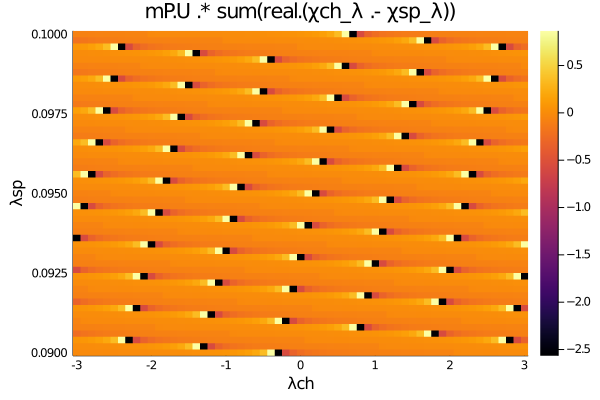

In [101]:
heatmap(λch_range_c2, λsp_range_c2, lhs_overview, xlabel="λch", ylabel="λsp", title="mP.U .* sum(real.(χch_λ .- χsp_λ))")
#savefig("lhs.pdf")

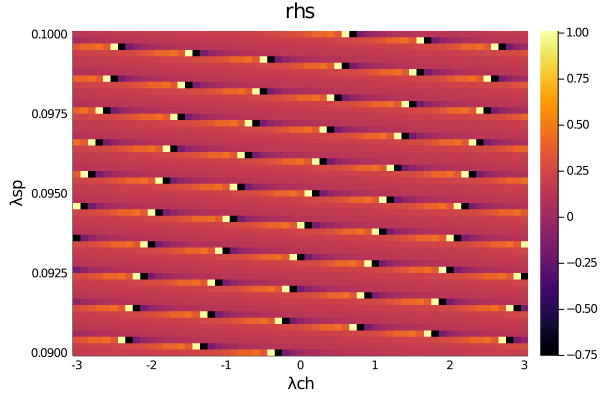

In [102]:
heatmap(λch_range_c2, λsp_range_c2, rhs_overview, xlabel="λch", ylabel="λsp", title="rhs")
#savefig("rhs.pdf")

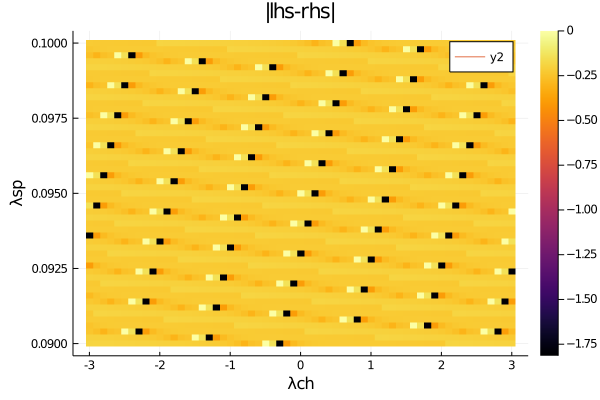

In [103]:
heatmap(λch_range_c2, λsp_range_c2, lhs_overview .- rhs_overview, xlabel="λch", ylabel="λsp", title="|lhs-rhs|")
#savefig("lhs_rhs.pdf")
plot!([0.095])

In [104]:
writedlm("cond2.csv",  lhs_overview .- rhs_overview, ' ')

In [141]:
arr_tmp = lhs_overview .- rhs_overview
open("cond2_2.txt", "w") do f
    for i in 1:size(arr_tmp,1)
        for j in 1:size(arr_tmp,2)
            @printf(f, "  %18.10f  %18.10f  %18.10f\n", λch_range_c2[i] , λsp_range_c2[j], arr_tmp[i,j])

            #str = string(λch_range_c2[i] ,"\t", λsp_range_c2[j] , "\t", arr_tmp[i,j], "\n")
            #write(io, str)
            #println(str)
        end
        @printf(f, "\n")
    end
end

In [133]:
abs.(arr_tmp)[:,25:end]

61×27 Array{Float64,2}:
 0.245388  0.000368725  0.13659   1.81385  …  0.22722   0.228013  0.228812
 0.24543   0.0003051    0.136805  1.81387     0.227245  0.228039  0.228838
 0.245472  0.000242123  0.137018  1.81388     0.227271  0.228064  0.228864
 0.245513  0.000179786  0.137228  1.8139      0.227296  0.228089  0.228889
 0.245554  0.000118075  0.137436  1.81392     0.227321  0.228114  0.228913
 0.245594  5.6982e-5    0.137642  1.81394  …  0.227345  0.228139  0.228938
 0.245634  3.505e-6     0.137845  1.81396     0.22737   0.228163  0.228962
 0.245673  6.33957e-5   0.138047  1.81398     0.227394  0.228187  0.228986
 0.245712  0.0001227    0.138246  1.81399     0.227418  0.228211  0.22901
 0.245751  0.000181428  0.138443  1.81401     0.227441  0.228235  0.229033
 0.245789  0.000239589  0.138638  1.81403  …  0.227465  0.228258  0.229057
 0.245826  0.000297191  0.138831  1.81404     0.227488  0.228281  0.22908
 0.245864  0.000354245  0.139022  1.81406     0.227511  0.228304  0.229102
 ⋮ 

In [138]:
abs.(arr_tmp)[3,26]

0.0002421233419692692

In [140]:
c2_zeros_ind = findall(x -> x < 0.005, abs.(arr_tmp))

61-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 26)
 CartesianIndex(2, 26)
 CartesianIndex(3, 26)
 CartesianIndex(4, 26)
 CartesianIndex(5, 26)
 CartesianIndex(6, 26)
 CartesianIndex(7, 26)
 CartesianIndex(8, 26)
 CartesianIndex(9, 26)
 CartesianIndex(10, 26)
 CartesianIndex(11, 26)
 CartesianIndex(12, 26)
 CartesianIndex(13, 26)
 ⋮
 CartesianIndex(50, 26)
 CartesianIndex(51, 26)
 CartesianIndex(52, 26)
 CartesianIndex(53, 26)
 CartesianIndex(54, 26)
 CartesianIndex(55, 26)
 CartesianIndex(56, 26)
 CartesianIndex(57, 26)
 CartesianIndex(58, 26)
 CartesianIndex(59, 26)
 CartesianIndex(60, 26)
 CartesianIndex(61, 26)

In [120]:
λsp_range_c2[26]

0.095

In [126]:
λch_range_c2[1:25]

-3.0:0.1:-0.6

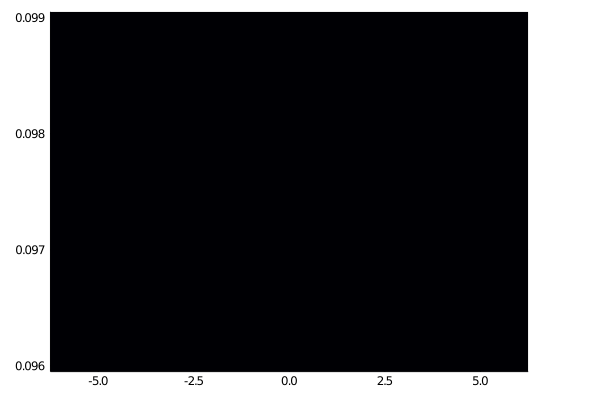

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


In [47]:
heatmap(λch_range_c2, λsp_range_c2, sign.(lhs_overview .- rhs_overview))

In [135]:
spOfch_max_int_c2 = zeros(length(spOfch_max_int))
spOfch2_max_int_c2 = zeros(length(spOfch2_max_int))


for (λi,(λchi, λspi)) in enumerate(zip(λch_range_c1, spOfch_max_int_c1))
    E_Poti = cond_Epot2(λspi, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Σ_loc, Σ_ladderLoc_cut, ϵkGrid_red, qIndices, usable_ω, 1:simParams.n_iν, 
                       modelParams, simParams)
    spOfch_max_int_c2[λi] = E_Poti
    print("\r", λi, " of ", length(spOfch2_c2_max_int))
end

for (λi,(λchi, λspi)) in enumerate(zip(λch_range2_c1, spOfch2_max_int_c1))
    E_Poti = cond_Epot2(λspi, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Σ_loc, Σ_ladderLoc_cut, ϵkGrid_red, qIndices, usable_ω, 1:simParams.n_iν, 
                       modelParams, simParams)
    spOfch2_max_int_c2[λi] = E_Poti
    print("\r", λi, " of ", length(spOfch2_c2_max_int))
end

81 of 81

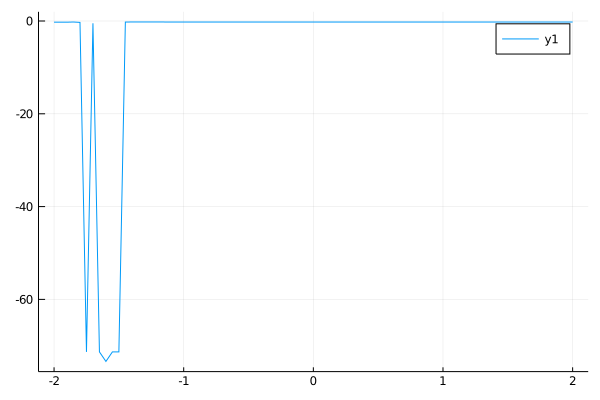

In [138]:
plot(λch_range_c1, spOfch2_max_int_c2)

In [144]:
using Roots

Xsp = @interval(0.09,0.1)
Xch = @interval(-2,2)
λch_range_c2 = -2:0.05:2
λch_range2_c2 = -20:0.5:20
spOfch_max_int_c2 = zeros(size(λch_range_c1))
spOfch2_max_int_c2 = zeros(size(λch_range2_c1))

for (λi,λchi) in enumerate(λch_range_c1)
    testf2(λsp) = cond_Epot2_r(λsp, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Σ_loc, Σ_ladderLoc_cut, ϵkGrid, qIndices, usable_ω, 1:simParams.n_iν, 
                       modelParams, simParams)
    spOfch_max_int_c2[λi] = mid(max_int)
    print("\r", λi, " of ", length(λch_range))
end

for (λi,λchi) in enumerate(λch_range2_c1)
    testf2(λsp) = cond_Epot2_r(λsp, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc_cut, ϵkGrid, qIndices, usable_ω, 1:simParams.n_iν, 
                   modelParams, simParams)
    spOfch2_max_int_c2[λi] = mid(max_int)
    print("\r", λi, " of ", length(λch_range2))
end

81 of 81

# Both conditions

In [156]:
function cond_both(λsp, λch, χsp, χch, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc, rhs, ϵkGrid, qIndices, usable_ω, usable_ν, mP, sP)
    χsp_λ = χ_λ(χsp, λsp)[usable_ω,:]
    χch_λ = χ_λ(χch, λch)[usable_ω,:]
    println(λsp, " ", λch)
    χsp_λ2 = typeof(λsp) <: Interval ? χ_λ(χsp, mid(λsp)) : χ_λ(χsp, λsp)
    χch_λ2 = typeof(λch) <: Interval ? χ_λ(χch, mid(λch)) : χ_λ(χch, λch)
    Σ_λ = calc_DΓA_Σ_fft(χsp_λ2, χch_λ2, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         ϵkGrid, qIndices, (1:(2*simParams.n_iω+1)), 1:simParams.n_iν, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Σ_λ_corrected = Σ_λ .- Σ_ladderLoc .+ Σ_loc[1:length(Σ_ladderLoc)]
    r1 =  sum(sum(χch_λ .+ χsp_λ, dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity)) - rhs
    E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid, mP, sP)
    r2 = mP.U * sum(real.(χch_λ .- χsp_λ)) ./ (mP.β*(sP.Nk^mP.D)) - E_Pot
    return SVector(r1, r2)
end


function cond_both_r!(F, λ, χsp, χch, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc, rhs, ϵkGrid, qIndices, usable_ω, usable_ν, mP, sP)
    χsp_λ = χ_λ(χsp, λ[1])[usable_ω,:]
    χch_λ = χ_λ(χch, λ[2])[usable_ω,:]
    println(λ)
    χsp_λ2 = typeof(λ[1]) <: Interval ? χ_λ(χsp, mid(λ[1])) : χ_λ(χsp, λ[1])
    χch_λ2 = typeof(λ[2]) <: Interval ? χ_λ(χch, mid(λ[2])) : χ_λ(χch, λ[2])
    Σ_λ = calc_DΓA_Σ_fft(χsp_λ2, χch_λ2, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         ϵkGrid, qIndices, (1:(2*simParams.n_iω+1)), 1:simParams.n_iν, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Σ_λ_corrected = Σ_λ .- Σ_ladderLoc .+ Σ_loc[1:length(Σ_ladderLoc)]
    E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid, mP, sP)
    F[1] = sum(sum(real.(χch_λ .+ χsp_λ), dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity)) - rhs
    F[2] = mP.U * sum(real.(χch_λ .- χsp_λ)) ./ (mP.β*(sP.Nk^mP.D)) - E_Pot
end

cond_both_r! (generic function with 1 method)

In [149]:
Xsp = @interval(0.09,0.1)
Xch = @interval(-2,2)
λch_range_c2 = -0.2:0.05:0.2 #0.2
λch_range2_c2 = -20:0.2:20 #0.2
spOfch_max_int_c2 = zeros(size(λch_range_c2))
testf3((λsp, λch)) = cond_both(λsp, λch, rχsp, rχch, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                           Σ_loc, Σ_ladderLoc_full, real(χLocsp + χLocch), ϵkGrid, qIndices, 1:size(bubble,1), 1:simParams.n_iν, 
                           modelParams, simParams)
res_internal = roots(testf3, Xsp × Xch, IntervalRootFinding.Bisection, 1e-2)

BoundsError: BoundsError: attempt to access 9×56 Array{Interval{Float64},2} at index [1:61, Base.Slice(Base.OneTo(56))]

In [158]:
testf3!(F,λ) = cond_both_r!(F, λ, χsp, χch, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                           Σ_loc, Σ_ladderLoc_full, real(χLocsp + χLocch), ϵkGrid_red, qIndices, 1:size(bubble,1), 1:simParams.n_iν, 
                           modelParams, simParams)
res_nls = nlsolve(testf3!, [0.096,0.1], method = :trust_region)

[0.096, 0.1]
[0.0960060554544524, 0.1]
[0.0959939445455476, 0.1]
[0.096, 0.1000060554544524]
[0.096, 0.09999394454554761]
[0.09801769787564481, -130.8958046889515]
[0.09801769787564481, -130.8958046889515]
[0.0980237533300972, -130.8958046889515]
[0.09801164242119241, -130.8958046889515]
[0.09801769787564481, -130.8950120553682]
[0.09801769787564481, -130.8965973225348]
[-0.1348204540870308, 110.74526102543453]
[-0.10877189505983545, 81.87841454065818]
[-0.007333344100511424, -30.535138743569277]
[0.04355314993854098, -86.92722592352459]
[0.06934081319474814, -115.5049493838073]
[0.08301829383558637, -130.66224593696288]
[0.08301829383558637, -130.66224593696288]
[0.08302434929003877, -130.66224593696288]
[0.08301223838113397, -130.66224593696288]
[0.08301829383558637, -130.66145471768397]
[0.08301829383558637, -130.66303715624178]
[0.06710834714231764, -133.18548017897635]
[0.06823517963648931, -135.35109360874398]
[0.07707139719917473, -139.09431765153087]
[0.07707139719917473, -139.

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.096, 0.1]
 * Zero: [0.07520747764264664, -142.35679212852952]
 * Inf-norm of residuals: 0.000000
 * Iterations: 33
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 29
 * Jacobian Calls (df/dx): 13

In [36]:
nh       = ceil(Int64, size(usable_ω,1)/2)
χsp_min    = -minimum(real.(1 ./ χsp[usable_ω[nh],:]))
χch_min    = -minimum(real.(1 ./ χch[usable_ω[nh],:]))
println("χsp_min: $(χsp_min)\nχch_min: $(χch_min)")

χsp_min: 0.02205518884088588
χch_min: -17.932849444809275


In [66]:
Xsp = @interval(-2,2)
Xch = @interval(-20,1)
λsp_range = -1:0.02:1
resi = zeros(size(λsp_range))
resi2 = zeros(size(λsp_range))
rχ_sp = real.(χsp[usable_ω,:])
rχ_ch = real.(χch[usable_ω,:])
for (λi,λsp) in enumerate(λsp_range)
    testf(λch) = construct_f(λsp, λch, rχ_sp, rχ_ch, qMultiplicity, rhs=real(χLocsp + χLocch))
    res_internal = roots(testf, Xch, Newton, 1e-8)
    max_int = maximum(interval.(res_internal))
    min_int = minimum(interval.(res_internal))
    resi[λi] = mid(max_int)
    resi2[λi] = mid(min_int)
    print("\r", λi, " of ", length(λsp_range))
end

101 of 101

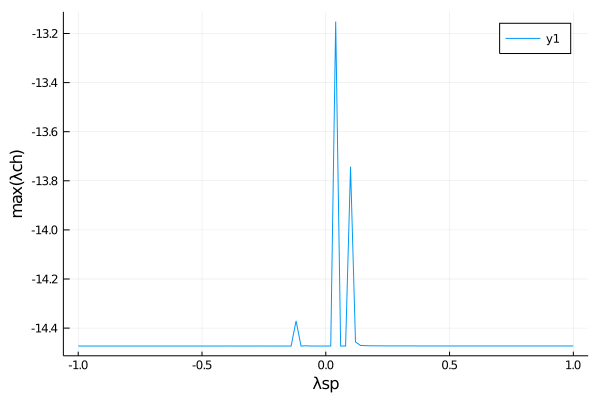

In [67]:
plot(λsp_range[1:end], resi[1:end], xlabel="λsp", ylabel="max(λch)")
#savefig("max_lambdach_of_lambdasp.pdf")

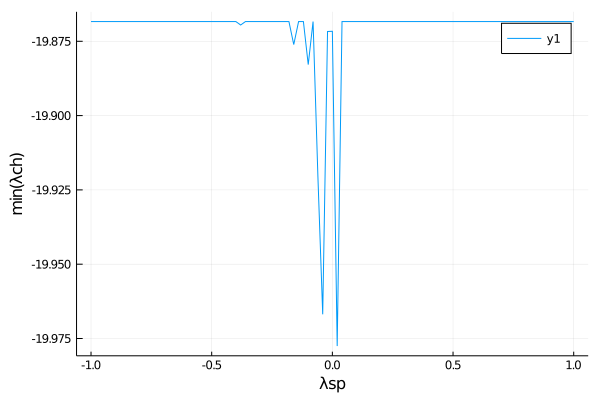

In [68]:
plot(λsp_range[1:end], resi2[1:end], xlabel="λsp", ylabel="min(λch)")
#savefig("min_lambdach_of_lambdasp.pdf")

In [69]:
res2 = interval.(res)
res3 = mid.(res2)
res4 = map(x -> [x[1], x[2]], res3)
res5 = collect(transpose(hcat(res4...)));

BoundsError: BoundsError

In [70]:
λch_range2 = -0.6:0.01:0.6
λsp_range2 = -0.5:0.01:0.5
res2 = zeros(length(λch_range2), length(λsp_range2))
ωrange = intersect(usable_ch, usable_sp)

for (i,λch_i) in enumerate(λch_range2)
    for (j,λsp_i) in enumerate(λsp_range2)
        res2[i,j] = construct_f( (λch_i, λsp_i),χch[ωrange,:], χsp[ωrange,:])  
    end
end

MethodError: MethodError: no method matching construct_f(::Tuple{Float64,Float64}, ::Array{Complex{Float64},2}, ::Array{Complex{Float64},2})
Closest candidates are:
  construct_f(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any; rhs) at In[21]:18

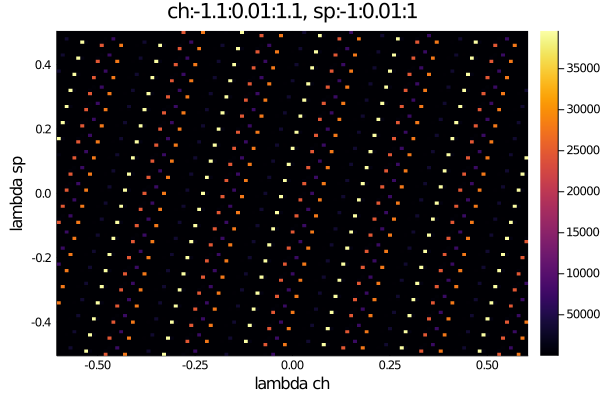

In [217]:
heatmap(λch_range2, λsp_range2, (res2 .- 0).^4, xlabel = "lambda ch", ylabel = "lambda sp", title="ch:-1.1:0.01:1.1, sp:-1:0.01:1")

In [349]:
χ_min_ch    = -minimum(1 ./ real.(χch[ceil(Int64,size(χch,1)/2),:]))
χ_min_sp    = -minimum(1 ./ real.(χsp[ceil(Int64,size(χch,1)/2),:]))
println(χ_min_ch, ", ", χ_min_sp)

-14.473154939042681, 0.09308725343569026


In [375]:
Xint = 0..1.1
fsp(λsp) =  construct_f(0.0, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
res_sp = IntervalRootFinding.roots(fsp, Xint, Newton, 1e-5)  
println(sort(interval.(res_sp)))
println(maximum(interval.(res_sp)))

Interval{Float64}[[0.0103389, 0.010339], [0.0143941, 0.0144021], [0.0225144, 0.0225147], [0.0236029, 0.023608], [0.0289026, 0.0289106], [0.0387014, 0.0387016], [0.049588, 0.0495966], [0.0626939, 0.062694], [0.0709535, 0.0709617], [0.0833816, 0.0833819], [0.0930821, 0.0930906], [0.0952014, 0.0952076]]
[0.0952014, 0.0952076]


In [377]:
Xint = (χ_min_ch-0.5)..(χ_min_ch+0.5)
χ_min_ch = -minimum(1 ./ real.(χch[floor(Int64,size(χch,1)/2),:]))
fch(λch) =  construct_f(λch, 0.0, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
res_ch = IntervalRootFinding.roots(fch, Xint)  
println(sort(interval.(res_ch)))
println(maximum(interval.(res_ch)))

Interval{Float64}[[227.512, 227.513], [227.514, 227.515]]
[227.514, 227.515]


In [333]:
Xint = -2..2
λch_range = -15:0.1:-14
χ_min_ch    = -minimum(1 ./ real.(χch[floor(Int64,size(χch,1)/2),:]))
res = zeros(length(λch_range))
for (i,λch_i) in enumerate(-15:0.1:-14)
    fsp_int(λsp) =  construct_f(λch_i, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
    res_sp = IntervalRootFinding.roots(fsp_int, Xint, Newton, 1e-3)
    res_sp_sort = sort(interval.(res_sp))
    println(res_sp_sort)
    res[i] = mid(maximum(interval.(res_sp)))
    println(i)
end

Interval{Float64}[[-0.656976, -0.65666], [-0.645462, -0.644907], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347508], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.30

Interval{Float64}[[-0.617177, -0.617105], [-0.614462, -0.614187], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.34791, -0.347435], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.615255, -0.614461], [-0.6068, -0.606756], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.347414, -0.346933], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.30

Interval{Float64}[[-0.668343, -0.667733], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347527], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.709881, -0.709333], [-0.707951, -0.707624], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347586], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

Interval{Float64}[[-0.738249, -0.738186], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400529, -0.400028], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347621], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

In [334]:
res

11-element Array{Float64,1}:
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237

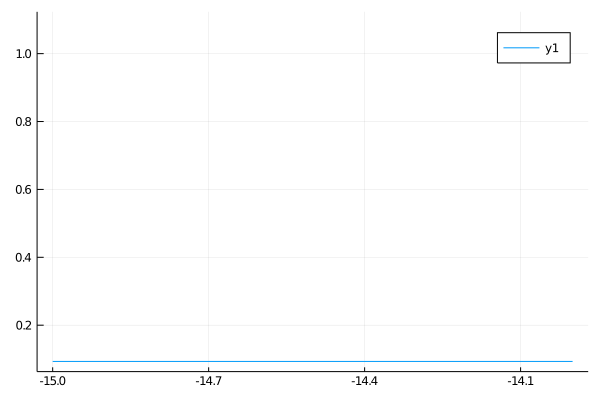

In [335]:
plot(λch_range, res)

In [310]:
Xint = -20..20
function f_full( (λch, λsp) ) 
    r = construct_f(λch, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
    return SVector(r,r)
end

function test( (λch, λsp) ) 
    r = λch + λsp
    return SVector(r,r)
end
    
res = IntervalRootFinding.roots(f_full, Xint × Xint, Newton, 1e-1)  
#println(sort(interval.(res)))
#println(maximum(interval.(res)))

InterruptException: InterruptException:

In [67]:
include("src/ladderDGA_Julia.jl")
include("test/loadFortranData.jl")

loadFortranData (generic function with 1 method)